In [124]:
%matplotlib inline
import pandas as pd
import numpy as np
from osgeo import gdal
from affine import Affine
import pyproj
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
import scipy.stats

In [61]:
def retrieve_pixel_value(geo_coord, data_source):
    """Return floating-point value that corresponds to given point."""
    print(data_source.GetGeoTransform())
    x, y = geo_coord[0], geo_coord[1]
    forward_transform =  affine.Affine.from_gdal(*data_source.GetGeoTransform())
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    px = int(px + 0.5) 
    py = int(py + 0.5)
    pixel_coord = px, py

    data_array = np.array(data_source.GetRasterBand(1).ReadAsArray())
    return data_array[pixel_coord[0]][pixel_coord[1]]

In [96]:
def retrieve_pixel_coords(geo_coord,geot_params):
    x, y = geo_coord[0], geo_coord[1]
    forward_transform =  Affine.from_gdal(*geot_params)
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    print('px size ', px.size)
    #px = int(px + 0.5)
    #py = int(py + 0.5)
    px = np.around(px).astype(int)
    py = np.around(py).astype(int)
    pixel_coord = px, py
    return pixel_coord

In [48]:
in_fn = '/Users/opizarro/data/FK20180119/bathy/au_au_clipped_UTM_4N.tif'
# EPSG:32604 is UTM 4N which is OK for Maui but cuts Hawaii Big island
# for others check http://spatialreference.org/
# test section of input data

in_ds = gdal.Open(in_fn)


print("Driver: {}/{}".format(in_ds.GetDriver().ShortName,
                             in_ds.GetDriver().LongName))
print("Size is {} x {} x {}".format(in_ds.RasterXSize,
                                    in_ds.RasterYSize,
                                    in_ds.RasterCount))
print("Projection is {}".format(in_ds.GetProjection()))
geotransform = in_ds.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

#off_ulx = 3300
#off_uly = 2000

off_ulx = 3600 #2800
off_uly = 1000
columns = 1000
rows = 800
print("\n--- reading subset with offset x {}, offset y {}, size columns {} and rows {} ".format(off_ulx,off_uly,columns,rows))
# read subset
in_data = in_ds.GetRasterBand(1).ReadAsArray(off_ulx, off_uly, columns, rows)
# projection doesn't change but the offsets are different
subset_ulx, subset_uly = gdal.ApplyGeoTransform(geotransform, off_ulx, off_uly)
out_gt = list(geotransform)
out_gt[0] = subset_ulx
out_gt[3] = subset_uly

gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create('/Users/opizarro/data/FK20180119/bathy_subset.tif', columns, rows, 1)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(out_gt)
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(in_data)


#np.save('/Users/opizarro/data/FK20180119/bathy_patch.npy',in_data)

#cell_width = 5
cell_width = np.abs(in_ds.GetGeoTransform()[1])
#cell_height = 5 
cell_height = np.abs(in_ds.GetGeoTransform()[5])
print("cell height ",cell_height)
print("cell width ",cell_width)
print("input data shape ",in_data.shape)


Driver: GTiff/GeoTIFF
Size is 6705 x 4788 x 1
Projection is PROJCS["WGS 84 / UTM zone 4N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-159],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32604"]]
Origin = (713498.999094, 2323086.99421)
Pixel Size = (4.99962942277, -4.9997952663)

--- reading subset with offset x 3600, offset y 1000, size columns 1000 and rows 800 
('cell height ', 4.9997952662983325)
('cell width ', 4.9996294227748201)
('input data shape ', (800, 1000))


In [ ]:
# load up image and cluster assignments
dfclusters=pd.read_json('/Users/opizarro/data/FK20180119/clusters_maui.json')

# coordinates in lat lon, convert to projection UTM 4N
utm_proj = pyproj.Proj('+proj=utm +zone=4 +ellps=WGS84')
#latlonc = dfclusters.as_matrix(columns =['Lon','Lat'])
#print(np.shape(latlonc))
#x,y = utm_proj(latlonc[:,0],latlonc[:,1])
#print(x.shape)

x,y = utm_proj(dfclusters.as_matrix(['Lon']),dfclusters.as_matrix(['Lat']))
print(x.shape)


# convert UTM x,y coords into pixel coords 
px, py = retrieve_pixel_coords([x,y],out_gt)
print(px)
print(py)

# select ones that are in bounds
xin = px[(px >=0) & (px < columns) & (py >= 0) & (py < rows)]
yin = py[(px >=0) & (px < columns) & (py >= 0) & (py < rows)]
print(xin,yin)
print(xin.shape)

# select clusterID in bounds
cIDall = dfclusters.as_matrix(['clusterID'])
cID = cIDall[(px >=0) & (px < columns) & (py >= 0) & (py < rows)]

# load bathymetric features
bfeats = np.load('/Users/opizarro/data/FK20180119/bfeatures.npy')
# add bathymetry
bathy_patch = np.load('/Users/opizarro/data/FK20180119/bathy_patch.npy')

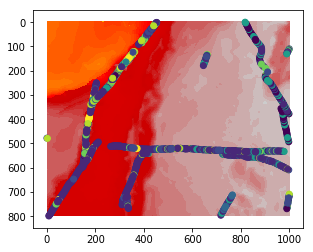

In [123]:
plt.figure(1)
plt.imshow(bathy_patch,cmap='nipy_spectral')
plt.scatter(xin,yin,c=cID)
plt.show()

In [113]:
print(dfclusters.head())

            Lat         Lon  clusterID
0     20.834259 -156.696257          1
1     20.839558 -156.778396          0
10    20.834463 -156.695972          5
100   20.832718 -156.698832          0
1000  20.829098 -156.703644          7


In [114]:
# extract bathy features at image positions
# input samples
print(bfeats.shape)
X = bfeats[yin,xin,:]
print(X.shape)

print(cID.shape)


(800, 1000, 16)
(1174, 16)
(1174,)


In [115]:
# set up classifier
clf = RandomForestClassifier(verbose=1)
clf.fit(X,cID)
print(clf.feature_importances_)


[ 0.07652027  0.07762545  0.07224303  0.05750467  0.06365647  0.06788235
  0.07613748  0.05951901  0.06300098  0.0483763   0.06383078  0.06308702
  0.0521684   0.04247     0.0575709   0.05840689]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [ ]:
# predictions for whole patch
brows,bcols,bchans = bfeats.shape
Xall = bfeats.reshape((brows*bcols,bchans))

cIDpred=clf.predict(Xall)
cIDim = cIDpred.reshape(brows,bcols)

(800, 1000)


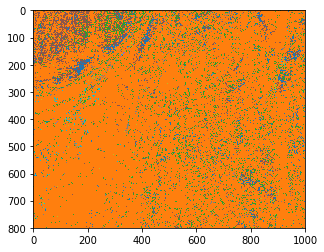

In [133]:
print(cIDim.shape)
plt.figure(2)
plt.imshow(cIDim,cmap='tab10')

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


(800000,)


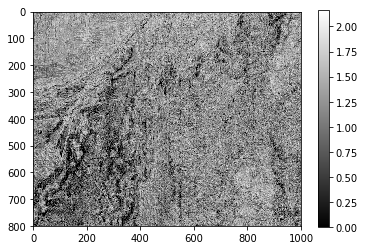

In [130]:
# plot entropy of predictions
cIDprobs = clf.predict_proba(Xall)
HcID = scipy.stats.entropy(np.transpose(cIDprobs))
print(HcID.shape)
plt.figure(3)
plt.imshow(HcID.reshape(brows,bcols),cmap='gray')
plt.colorbar()
plt.show()

(800000,)


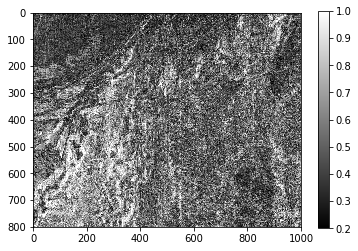

In [132]:
# plot max prob per cell
cIDmaxp = np.max(cIDprobs,axis=1)
print(cIDmaxp.shape)
plt.figure(4)
plt.imshow(cIDmaxp.reshape(brows,bcols),cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# figure out minimum distance in bspace to survey samples
# for each element in bfeats in area, calculate distance to bfeats in survey and select min distance
nall = Xall.shape[0]
nsurv = X.shape[0]
minD = float('inf')*np.ones((nall,))

for scounter in range(nsurv):
    delta = Xall - np.outer(np.ones((nall,)),X[scounter,:])
    D = np.linalg.norm(delta,axis=1)
    minD = np.minimum(minD,D)
    print('\r element {} out of {}'.format(scounter,nsurv)),

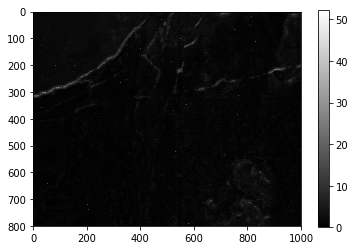

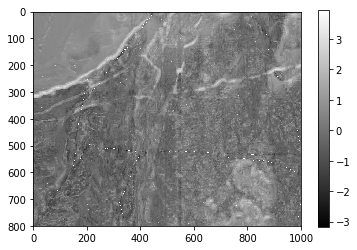

In [139]:
plt.figure(5)
plt.imshow(minD.reshape(brows,bcols),cmap='gray')
plt.colorbar()
plt.show()

# use log to compress high end
plt.figure(6)
plt.imshow(np.log(minD.reshape(brows,bcols)),cmap='gray')
plt.colorbar()
plt.show()

